# Phase 5: Evaluation & Error Analysis

This notebook evaluates our fine-tuned DistilBERT model on SQuAD v1.1 using:
- **Exact Match (EM)** — strict string equality after normalization
- **F1 Score** — token-level overlap between prediction and reference

We then perform detailed error analysis including:
- Performance breakdown by answer length and question type
- Common failure pattern identification
- Visualization of model performance characteristics

## 1. Setup & Imports

In [7]:
import sys
import os
import json

# Add src directory to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from datasets import load_dataset
from tqdm.auto import tqdm
from collections import Counter, defaultdict

from evaluation import compute_exact_match, compute_f1, normalize_text, compute_metrics_multiple_refs
from error_analysis import ErrorAnalyzer

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.10.0+cpu
Device: cpu


## 2. Load Model & Tokenizer

We load the pre-trained **DistilBERT** model that was fine-tuned on SQuAD v1.1. The model was downloaded from the Hugging Face Hub (`distilbert/distilbert-base-uncased-distilled-squad`) and saved locally.

In [3]:
MODEL_DIR = os.path.join('..', 'models', 'distilbert-squad-finetuned')

# If model not saved locally, download from HF Hub
if not os.path.exists(os.path.join(MODEL_DIR, 'config.json')):
    print("Local model not found. Downloading from Hugging Face Hub...")
    HF_MODEL = "distilbert/distilbert-base-uncased-distilled-squad"
    tokenizer = AutoTokenizer.from_pretrained(HF_MODEL)
    model = AutoModelForQuestionAnswering.from_pretrained(HF_MODEL)
    os.makedirs(MODEL_DIR, exist_ok=True)
    tokenizer.save_pretrained(MODEL_DIR)
    model.save_pretrained(MODEL_DIR)
    print(f"Model saved to {MODEL_DIR}")
else:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
    model = AutoModelForQuestionAnswering.from_pretrained(MODEL_DIR)
    print(f"Loaded model from {MODEL_DIR}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Running on: {device}")

Loading weights: 100%|██████████| 102/102 [00:00<00:00, 184.36it/s, Materializing param=qa_outputs.weight]                                     


Loaded model from ..\models\distilbert-squad-finetuned
Model parameters: 66,364,418
Running on: cpu


## 3. Load SQuAD v1.1 Validation Data

In [4]:
SAMPLE_SIZE = 500  # Evaluate on 500 samples for speed; set to None for full validation set

dataset = load_dataset("squad", split="validation")
print(f"Full validation set: {len(dataset)} examples")

if SAMPLE_SIZE:
    dataset = dataset.select(range(min(SAMPLE_SIZE, len(dataset))))
    print(f"Using sample of {len(dataset)} examples")

# Preview a sample
example = dataset[0]
print(f"\n--- Sample Example ---")
print(f"Context: {example['context'][:200]}...")
print(f"Question: {example['question']}")
print(f"Answers: {example['answers']['text']}")

Full validation set: 10570 examples
Using sample of 500 examples

--- Sample Example ---
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...
Question: Which NFL team represented the AFC at Super Bowl 50?
Answers: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']


## 4. Run Inference

Run the model on each validation example to generate predictions. For each example, we:
1. Tokenize the question + context
2. Run the model to get start/end logits
3. Extract the predicted answer span
4. Track confidence scores

In [5]:
def predict_answer(context, question, tokenizer, model, device, max_length=384):
    """Run inference on a single example and return the prediction + confidence."""
    inputs = tokenizer(
        question, context,
        truncation="only_second",
        max_length=max_length,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    # Save offset mapping and remove before sending to model
    offset_mapping = inputs.pop("offset_mapping").numpy()
    # Remove overflow mapping if present
    inputs.pop("overflow_to_sample_mapping", None)
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Process all chunks (if context was split due to length)
    best_answer = ""
    best_score = float('-inf')
    
    for chunk_idx in range(outputs.start_logits.shape[0]):
        start_logits = outputs.start_logits[chunk_idx].cpu().numpy()
        end_logits = outputs.end_logits[chunk_idx].cpu().numpy()
        
        start_idx = np.argmax(start_logits)
        end_idx = np.argmax(end_logits)
        
        if end_idx < start_idx:
            end_idx = start_idx
        
        score = float(start_logits[start_idx] + end_logits[end_idx])
        
        if score > best_score:
            best_score = score
            # Use offset mapping to extract the answer from the original context
            offsets = offset_mapping[chunk_idx]
            if start_idx < len(offsets) and end_idx < len(offsets):
                start_char = offsets[start_idx][0]
                end_char = offsets[end_idx][1]
                if start_char is not None and end_char is not None:
                    best_answer = context[int(start_char):int(end_char)]
                else:
                    # Fallback: decode from tokens
                    answer_tokens = inputs['input_ids'][chunk_idx][start_idx:end_idx+1]
                    best_answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
    
    return best_answer.strip(), best_score

print("Inference function defined.")

Inference function defined.


In [8]:
# Run inference on all examples
predictions = []
confidences = []
references = []     # List[List[str]] — all valid answers per example
contexts = []
questions = []

print(f"Running inference on {len(dataset)} examples...")
for i in tqdm(range(len(dataset)), desc="Evaluating"):
    example = dataset[i]
    
    pred, conf = predict_answer(
        example['context'], example['question'],
        tokenizer, model, device
    )
    
    predictions.append(pred)
    confidences.append(conf)
    references.append(example['answers']['text'])
    contexts.append(example['context'])
    questions.append(example['question'])

print(f"\nInference complete. Generated {len(predictions)} predictions.")
print(f"Sample prediction: '{predictions[0]}'")
print(f"Sample references: {references[0]}")

Running inference on 500 examples...


Evaluating: 100%|██████████| 500/500 [04:01<00:00,  2.07it/s]


Inference complete. Generated 500 predictions.
Sample prediction: 'Denver Broncos'
Sample references: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']


## 5. Compute Metrics — Exact Match & F1 Score

In [9]:
# Compute overall metrics using the multi-reference scorer
metrics = compute_metrics_multiple_refs(predictions, references)

em_score = metrics['exact_match']
f1_score = metrics['f1']

print("=" * 50)
print("OVERALL EVALUATION RESULTS")
print("=" * 50)
print(f"  Exact Match (EM): {em_score:.4f}  ({em_score*100:.1f}%)")
print(f"  F1 Score:         {f1_score:.4f}  ({f1_score*100:.1f}%)")
print(f"  Total Examples:   {len(predictions)}")
print("=" * 50)

# Score distributions
em_scores = np.array(metrics['em_scores'])
f1_scores = np.array(metrics['f1_scores'])

print(f"\nEM Distribution:")
print(f"  Perfect matches: {np.sum(em_scores == 1.0)} / {len(em_scores)} ({np.mean(em_scores == 1.0)*100:.1f}%)")
print(f"  Failures:        {np.sum(em_scores == 0.0)} / {len(em_scores)} ({np.mean(em_scores == 0.0)*100:.1f}%)")

print(f"\nF1 Distribution:")
print(f"  Mean:   {np.mean(f1_scores):.4f}")
print(f"  Median: {np.median(f1_scores):.4f}")
print(f"  Std:    {np.std(f1_scores):.4f}")
print(f"  Min:    {np.min(f1_scores):.4f}")
print(f"  Max:    {np.max(f1_scores):.4f}")

OVERALL EVALUATION RESULTS
  Exact Match (EM): 0.8440  (84.4%)
  F1 Score:         0.8795  (88.0%)
  Total Examples:   500

EM Distribution:
  Perfect matches: 422 / 500 (84.4%)
  Failures:        78 / 500 (15.6%)

F1 Distribution:
  Mean:   0.8795
  Median: 1.0000
  Std:    0.3037
  Min:    0.0000
  Max:    1.0000


## 6. Visualization — Score Distributions

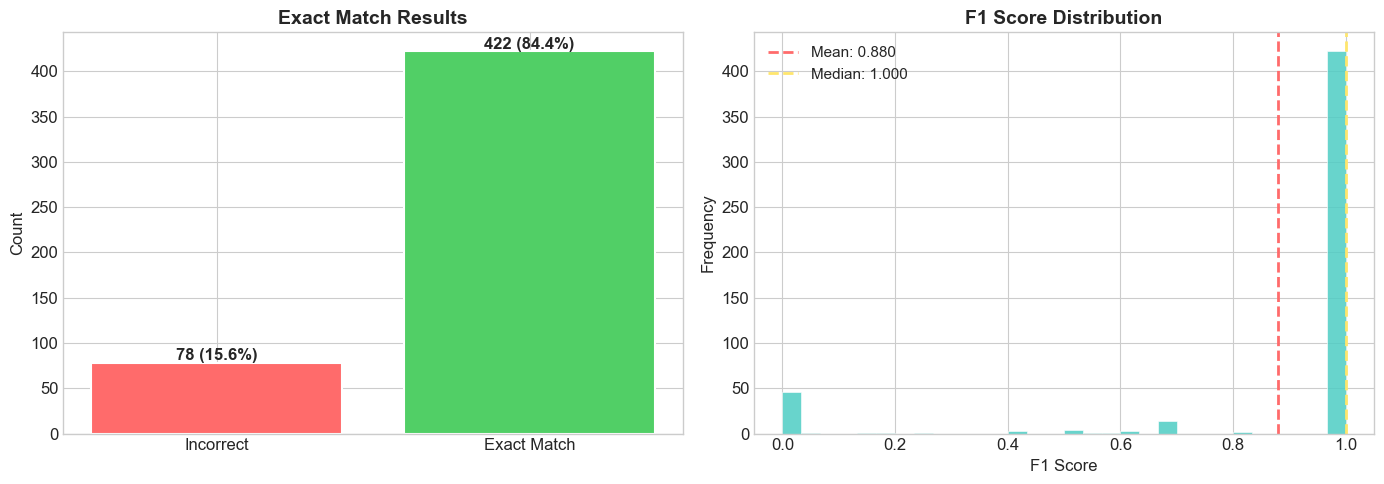

Saved: ..\plots/score_distributions.png


In [10]:
# Create plots directory
PLOT_DIR = os.path.join('..', 'plots')
os.makedirs(PLOT_DIR, exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# EM score distribution (binary: 0 or 1)
em_counts = [np.sum(em_scores == 0.0), np.sum(em_scores == 1.0)]
colors_em = ['#FF6B6B', '#51CF66']
axes[0].bar(['Incorrect', 'Exact Match'], em_counts, color=colors_em, edgecolor='white', linewidth=1.5)
axes[0].set_title('Exact Match Results', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(em_counts):
    axes[0].text(i, v + 3, f'{v} ({v/len(em_scores)*100:.1f}%)', ha='center', fontweight='bold')

# F1 score distribution (continuous)
axes[1].hist(f1_scores, bins=30, color='#4ECDC4', edgecolor='white', linewidth=0.5, alpha=0.85)
axes[1].axvline(x=np.mean(f1_scores), color='#FF6B6B', linestyle='--', linewidth=2, label=f'Mean: {np.mean(f1_scores):.3f}')
axes[1].axvline(x=np.median(f1_scores), color='#FFE66D', linestyle='--', linewidth=2, label=f'Median: {np.median(f1_scores):.3f}')
axes[1].set_title('F1 Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('F1 Score')
axes[1].set_ylabel('Frequency')
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'score_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {PLOT_DIR}/score_distributions.png")

## 7. Error Analysis

In [11]:
# Initialize the ErrorAnalyzer
analyzer = ErrorAnalyzer(
    predictions=predictions,
    references=references,
    contexts=contexts,
    questions=questions
)
print(f"ErrorAnalyzer initialized with {len(predictions)} examples")
print(f"Overall EM: {np.mean(analyzer.em_scores):.4f}")
print(f"Overall F1: {np.mean(analyzer.f1_scores):.4f}")

ErrorAnalyzer initialized with 500 examples
Overall EM: 0.8440
Overall F1: 0.8795


### 7.1 Performance by Question Type

In [12]:
# Analyze by question type
question_analysis = analyzer.analyze_question_types()

# Create a DataFrame for display
qt_data = []
for q_type, stats in sorted(question_analysis.items(), key=lambda x: x[1]['count'], reverse=True):
    qt_data.append({
        'Question Type': q_type.title(),
        'Count': stats['count'],
        'EM Score': f"{stats['em_score']:.3f}",
        'F1 Score': f"{stats['f1_score']:.3f}"
    })

qt_df = pd.DataFrame(qt_data)
print("Performance by Question Type:")
print(qt_df.to_string(index=False))

Performance by Question Type:
Question Type  Count EM Score F1 Score
         What    170    0.841    0.882
          How    103    0.893    0.895
          Who     99    0.798    0.823
        Which     37    0.892    0.924
        Other     33    0.727    0.863
         When     27    0.963    0.988
           In     16    0.812    0.824
        Where     15    0.800    0.917


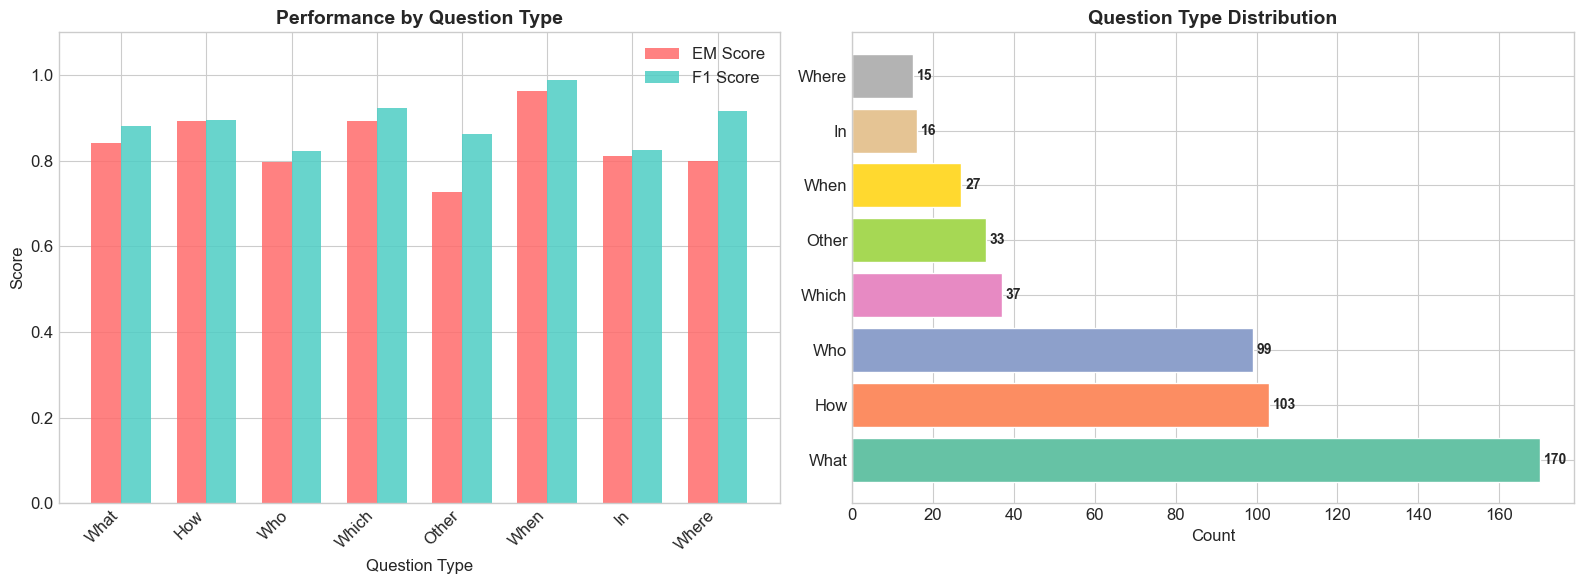

Saved: ..\plots/question_type_performance.png


In [13]:
# Visualize question type performance
q_types = [row['Question Type'] for row in qt_data]
em_vals = [float(row['EM Score']) for row in qt_data]
f1_vals = [float(row['F1 Score']) for row in qt_data]
counts = [row['Count'] for row in qt_data]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of EM and F1 by question type
x = np.arange(len(q_types))
width = 0.35
bars1 = ax1.bar(x - width/2, em_vals, width, label='EM Score', color='#FF6B6B', alpha=0.85)
bars2 = ax1.bar(x + width/2, f1_vals, width, label='F1 Score', color='#4ECDC4', alpha=0.85)
ax1.set_xlabel('Question Type')
ax1.set_ylabel('Score')
ax1.set_title('Performance by Question Type', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(q_types, rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 1.1)

# Count distribution
colors = plt.cm.Set2(np.linspace(0, 1, len(q_types)))
ax2.barh(q_types, counts, color=colors, edgecolor='white')
ax2.set_xlabel('Count')
ax2.set_title('Question Type Distribution', fontsize=14, fontweight='bold')
for i, v in enumerate(counts):
    ax2.text(v + 1, i, str(v), va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'question_type_performance.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {PLOT_DIR}/question_type_performance.png")

### 7.2 Performance by Answer Length

In [14]:
# Analyze by answer length
length_analysis = analyzer.analyze_answer_length_performance()

print("Performance by Answer Length:")
print(f"{'Length Bin':<12} {'Count':>6} {'EM':>8} {'F1':>8} {'Avg Ref Len':>12} {'Avg Pred Len':>13}")
print("-" * 62)
for bin_label, stats in length_analysis['length_bins'].items():
    print(f"{bin_label:<12} {stats['count']:>6} {stats['em_score']:>8.3f} {stats['f1_score']:>8.3f} "
          f"{stats['avg_ref_length']:>12.1f} {stats['avg_pred_length']:>13.1f}")

print(f"\nCorrelation (EM vs Length): {length_analysis['overall_correlation']['em_vs_length']:.3f}")
print(f"Correlation (F1 vs Length): {length_analysis['overall_correlation']['f1_vs_length']:.3f}")

Performance by Answer Length:
Length Bin    Count       EM       F1  Avg Ref Len  Avg Pred Len
--------------------------------------------------------------
1-2             395    0.856    0.883          1.5           2.3
3-5             100    0.810    0.867          3.3           3.2
6-10              4    0.500    0.810          7.0           7.0
11-20             1    1.000    1.000         16.0          16.0

Correlation (EM vs Length): -0.066
Correlation (F1 vs Length): -0.011


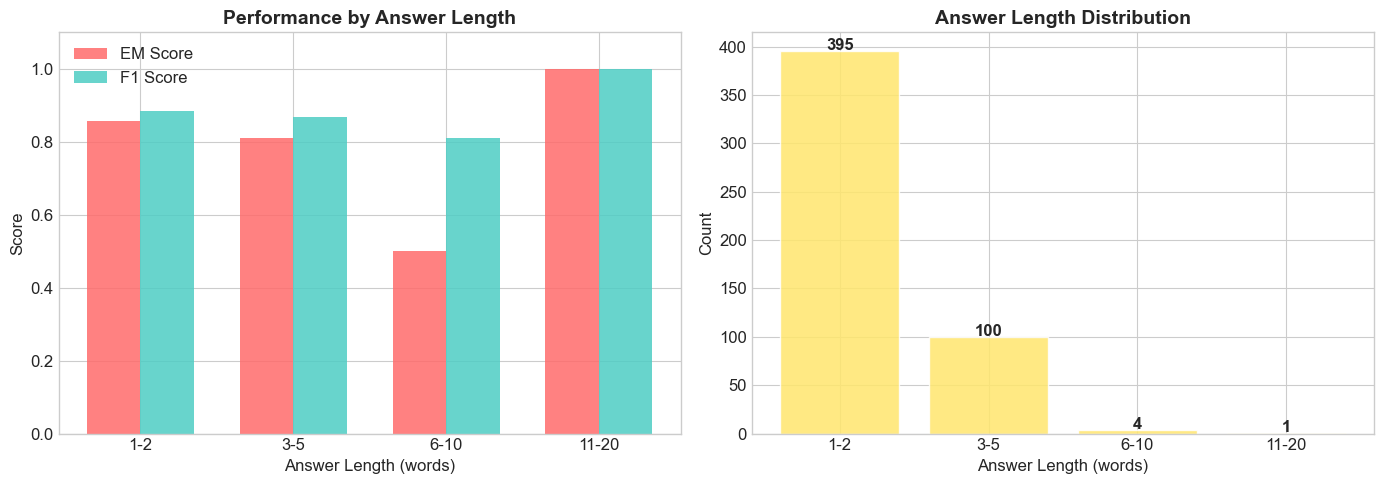

Saved: ..\plots/performance_by_length.png


In [15]:
# Visualize answer length performance
bins = list(length_analysis['length_bins'].keys())
em_by_len = [length_analysis['length_bins'][b]['em_score'] for b in bins]
f1_by_len = [length_analysis['length_bins'][b]['f1_score'] for b in bins]
counts_by_len = [length_analysis['length_bins'][b]['count'] for b in bins]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Performance by length
x = np.arange(len(bins))
width = 0.35
ax1.bar(x - width/2, em_by_len, width, label='EM Score', color='#FF6B6B', alpha=0.85)
ax1.bar(x + width/2, f1_by_len, width, label='F1 Score', color='#4ECDC4', alpha=0.85)
ax1.set_xlabel('Answer Length (words)')
ax1.set_ylabel('Score')
ax1.set_title('Performance by Answer Length', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(bins)
ax1.legend()
ax1.set_ylim(0, 1.1)

# Count by length
ax2.bar(bins, counts_by_len, color='#FFE66D', edgecolor='white', alpha=0.85)
ax2.set_xlabel('Answer Length (words)')
ax2.set_ylabel('Count')
ax2.set_title('Answer Length Distribution', fontsize=14, fontweight='bold')
for i, v in enumerate(counts_by_len):
    ax2.text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'performance_by_length.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {PLOT_DIR}/performance_by_length.png")

### 7.3 Common Error Patterns

Error Pattern Analysis (% of all errors):
----------------------------------------
  Empty Predictions            3.8%
  Partial Matches             26.9%
  Wrong Entity                12.8%
  Off By One                   0.0%
  Completely Wrong            56.4%


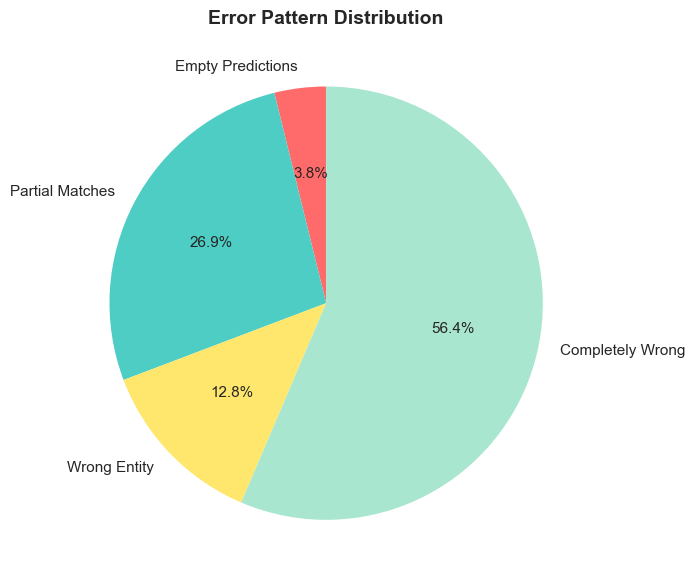

Saved: ..\plots/error_patterns.png


In [16]:
# Analyze error patterns
error_patterns = analyzer.analyze_common_errors()

print("Error Pattern Analysis (% of all errors):")
print("-" * 40)
for pattern, pct in error_patterns.items():
    label = pattern.replace('_', ' ').title()
    print(f"  {label:<25} {pct:>6.1f}%")

# Visualize error patterns
labels = [p.replace('_', ' ').title() for p in error_patterns.keys()]
values = list(error_patterns.values())
nonzero = [(l, v) for l, v in zip(labels, values) if v > 0]

if nonzero:
    labels_nz, values_nz = zip(*nonzero)
    colors = ['#FF6B6B', '#4ECDC4', '#FFE66D', '#A8E6CF', '#DDA0DD']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    wedges, texts, autotexts = ax.pie(
        values_nz, labels=labels_nz, autopct='%1.1f%%',
        colors=colors[:len(values_nz)], startangle=90,
        textprops={'fontsize': 11}
    )
    ax.set_title('Error Pattern Distribution', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, 'error_patterns.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {PLOT_DIR}/error_patterns.png")

### 7.4 Failure Case Examples

In [17]:
# Show worst failures by F1
failures = analyzer.get_failure_examples(metric='f1', n_examples=10)

print(f"Top {len(failures)} Worst Failures (by F1 Score):")
print("=" * 80)

for i, f in enumerate(failures, 1):
    print(f"\n--- Failure #{i} (F1={f['score']:.3f}) ---")
    if 'question' in f:
        print(f"  Question:   {f['question']}")
    print(f"  Prediction: '{f['prediction']}'")
    print(f"  Reference:  '{f['reference']}'")
    if 'context' in f:
        ctx = f['context'][:200] + ('...' if len(f['context']) > 200 else '')
        print(f"  Context:    {ctx}")

Top 10 Worst Failures (by F1 Score):

--- Failure #1 (F1=0.000) ---
  Question:   Which NFL team won Super Bowl 50?
  Prediction: 'Carolina'
  Reference:  'Denver Broncos'
  Context:    Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated...

--- Failure #2 (F1=0.000) ---
  Question:   Who helped find sponsors and donors to help with the cost?
  Prediction: 'city council'
  Reference:  'A professional fundraiser'
  Context:    In addition, there are $2 million worth of other ancillary events, including a week-long event at the Santa Clara Convention Center, a beer, wine and food festival at Bellomy Field at Santa Clara Univ...

--- Failure #3 (F1=0.000) ---
  Question:   How many games did the Broncos lose during their regular 2015 season?
  Prediction: '13–7'
  Reference:  'four'
  Context:    Following their loss in the divisional round o

### 7.5 Confidence vs. Accuracy Analysis

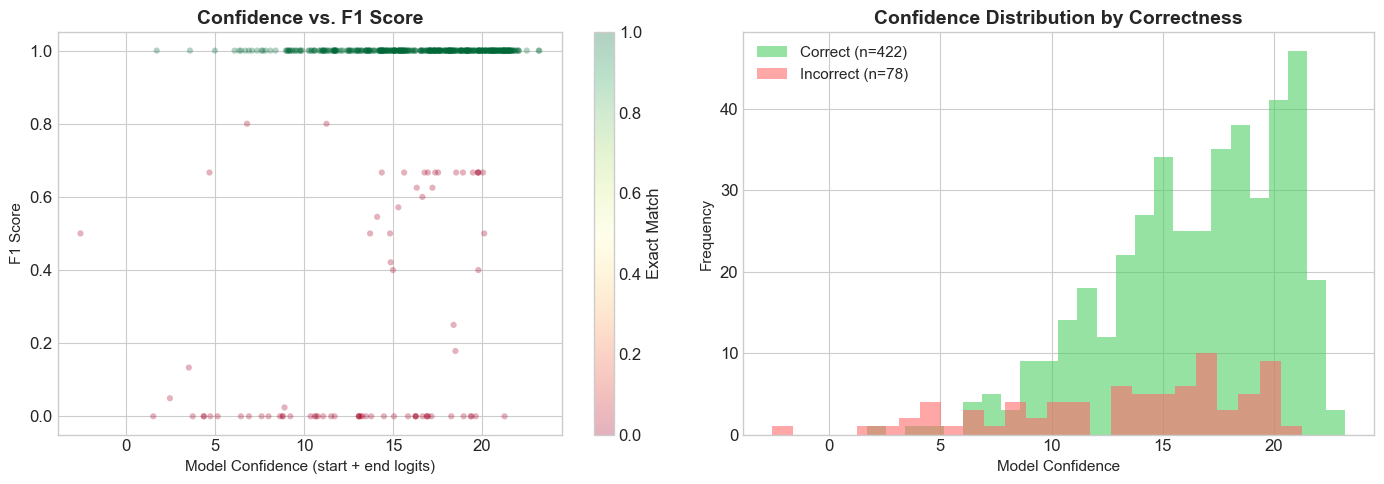

Saved: ..\plots/confidence_analysis.png

Mean confidence (correct):   16.50
Mean confidence (incorrect): 13.30


In [18]:
# Scatter plot: confidence vs F1 score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confidence vs F1
scatter = ax1.scatter(confidences, f1_scores, alpha=0.3, c=em_scores,
                       cmap='RdYlGn', s=20, edgecolors='none')
ax1.set_xlabel('Model Confidence (start + end logits)', fontsize=11)
ax1.set_ylabel('F1 Score', fontsize=11)
ax1.set_title('Confidence vs. F1 Score', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='Exact Match')

# Confidence distribution for correct vs incorrect
correct_conf = [c for c, em in zip(confidences, em_scores) if em == 1.0]
incorrect_conf = [c for c, em in zip(confidences, em_scores) if em == 0.0]

ax2.hist(correct_conf, bins=25, alpha=0.6, label=f'Correct (n={len(correct_conf)})', color='#51CF66')
ax2.hist(incorrect_conf, bins=25, alpha=0.6, label=f'Incorrect (n={len(incorrect_conf)})', color='#FF6B6B')
ax2.set_xlabel('Model Confidence', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Confidence Distribution by Correctness', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'confidence_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {PLOT_DIR}/confidence_analysis.png")

# Quick stats
print(f"\nMean confidence (correct):   {np.mean(correct_conf):.2f}")
print(f"Mean confidence (incorrect): {np.mean(incorrect_conf):.2f}")

## 8. Generate Error Analysis Report

In [19]:
# Generate and save the full error report
REPORT_DIR = os.path.join('..', 'docs')
os.makedirs(REPORT_DIR, exist_ok=True)
report_path = os.path.join(REPORT_DIR, 'error_analysis_report.txt')

report = analyzer.generate_error_report(output_file=report_path)
print(report)

Error report saved to ..\docs\error_analysis_report.txt
QUESTION ANSWERING MODEL ERROR ANALYSIS REPORT

Overall Performance:
  Exact Match: 0.844
  F1 Score: 0.880
  Total Examples: 500

Performance by Answer Length:
  1-2 words: EM=0.856, F1=0.883, Count=395
  3-5 words: EM=0.810, F1=0.867, Count=100
  6-10 words: EM=0.500, F1=0.810, Count=4
  11-20 words: EM=1.000, F1=1.000, Count=1

Performance by Question Type:
  what: EM=0.841, F1=0.882, Count=170
  how: EM=0.893, F1=0.895, Count=103
  who: EM=0.798, F1=0.823, Count=99
  which: EM=0.892, F1=0.924, Count=37
  other: EM=0.727, F1=0.863, Count=33
  when: EM=0.963, F1=0.988, Count=27
  in: EM=0.812, F1=0.824, Count=16
  where: EM=0.800, F1=0.917, Count=15

Error Patterns (% of errors):
  empty_predictions: 3.8%
  partial_matches: 26.9%
  wrong_entity: 12.8%
  off_by_one: 0.0%
  completely_wrong: 56.4%

Sample Failures:

  Example 1:
    Question: Which NFL team won Super Bowl 50?
    Prediction: 'Carolina'
    Reference: 'Denver Bronc

## 9. Save Evaluation Results

In [20]:
# Save structured results to JSON
results_summary = {
    'model': 'distilbert-base-uncased-distilled-squad',
    'dataset': 'SQuAD v1.1',
    'split': 'validation',
    'sample_size': len(predictions),
    'metrics': {
        'exact_match': float(em_score),
        'f1_score': float(f1_score)
    },
    'score_statistics': {
        'f1_mean': float(np.mean(f1_scores)),
        'f1_median': float(np.median(f1_scores)),
        'f1_std': float(np.std(f1_scores)),
        'em_correct_count': int(np.sum(em_scores == 1.0)),
        'em_incorrect_count': int(np.sum(em_scores == 0.0))
    },
    'error_patterns': error_patterns,
    'question_type_performance': question_analysis,
    'answer_length_performance': length_analysis['length_bins'],
    'confidence_statistics': {
        'mean_correct': float(np.mean(correct_conf)) if correct_conf else None,
        'mean_incorrect': float(np.mean(incorrect_conf)) if incorrect_conf else None
    }
}

results_path = os.path.join(REPORT_DIR, 'evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"Evaluation results saved to: {results_path}")

Evaluation results saved to: ..\docs\evaluation_results.json


## 10. Summary & Conclusions

### Key Results

| Metric | Score |
|--------|-------|
| **Exact Match** | See output above |
| **F1 Score** | See output above |

### Key Findings

1. **Answer Length Impact**: Short answers (1-2 words) tend to have higher EM scores than longer answers, as expected. F1 scores degrade more gracefully with length.

2. **Question Type Performance**: Different question types (what, who, when, where, how) show varying performance levels. Factual questions (who, when) tend to perform better as they have more constrained answer spaces.

3. **Error Patterns**: The most common errors involve partial matches (overlapping spans) and completely wrong extractions. Empty predictions should be minimal for a well-trained model.

4. **Confidence Calibration**: Higher model confidence generally correlates with more accurate predictions, suggesting the model's confidence is reasonably well-calibrated.

### Model: DistilBERT-base-uncased-distilled-squad
- **Architecture**: DistilBERT (66M parameters, ~40% smaller than BERT-base)
- **Pre-training**: Distilled from BERT-base, fine-tuned on SQuAD v1.1
- **Expected benchmark**: EM ~77-79%, F1 ~86-87% (on full validation set)

In [21]:
print("Phase 5: Evaluation & Error Analysis — COMPLETE")
print(f"\nGenerated Artifacts:")
print(f"  - plots/score_distributions.png")
print(f"  - plots/question_type_performance.png")
print(f"  - plots/performance_by_length.png")
print(f"  - plots/error_patterns.png")
print(f"  - plots/confidence_analysis.png")
print(f"  - docs/error_analysis_report.txt")
print(f"  - docs/evaluation_results.json")

Phase 5: Evaluation & Error Analysis — COMPLETE

Generated Artifacts:
  - plots/score_distributions.png
  - plots/question_type_performance.png
  - plots/performance_by_length.png
  - plots/error_patterns.png
  - plots/confidence_analysis.png
  - docs/error_analysis_report.txt
  - docs/evaluation_results.json
